# SF6 Rank Distribution Explorer  


Web scrapes the official SF6 website for the player count in each rank.  
Provides 3 visualizations of the rank distribution, along with its data frames.  
- Bar chart where each bar is a rank and its corresponding player count
- Stacked Bar Chart where each bar is a rank group and its corresponding player count
- Chart of all the ranks stacked in cumulative percentile to show the percentile that each rank is in 

<hr>  

## Gathering Data

In [17]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from selenium.webdriver.support.wait import WebDriverWait
from selenium.common import NoSuchElementException, ElementNotInteractableException, StaleElementReferenceException

### Accessing the Leaderboards

In [18]:
# Log in to SF6 Website
driver = webdriver.Chrome()
driver.get("https://www.streetfighter.com/6/buckler/ranking/league")


homepage_log_in_button = driver.find_element(By.LINK_TEXT, "Log in/Sign up")
homepage_log_in_button.click()


# Create a variable of exempt errors to use when setting explicit waits
exempt_wait_errors = [NoSuchElementException, ElementNotInteractableException, StaleElementReferenceException]
wait = WebDriverWait(driver, timeout=10, poll_frequency=.2, ignored_exceptions=exempt_wait_errors)


# Wait for the "country" dropdown element to be displayed to ensure the "age check" page loaded completely first
wait.until(lambda _: (driver.find_element(By.ID, "country")).is_displayed())


# Complete the age check form
def dropdown_value_select_by_id(web_element, value):
    """
    Input web element ID and the desired value for the select tag
    """
    dropdown = driver.find_element(By.ID, web_element)
    Select(dropdown).select_by_value(value)


dropdown_value_select_by_id("country", "US")
dropdown_value_select_by_id("birthDay", "1")
dropdown_value_select_by_id("birthYear", "2000")
dropdown_value_select_by_id("birthMonth", "1")

submit_button = driver.find_element(By.NAME, "submit")
submit_button.click()


# Wait for expected element to be displayed
wait.until(lambda _: (driver.find_element(By.NAME, "email")).is_displayed())


# Read log in credentials from a separate file in the same folder in order to make sure the credentials are separate from the code itself
log_in_credentials_file_path = "C:\\Users\\Binaryxx Sune\\Documents\\Programming\\personal_projects\\sf6_rank_dist\\capcom_cred.txt"
with open(log_in_credentials_file_path) as log_in_credentials_file:
    email, password = log_in_credentials_file.readlines()

email_textbox = driver.find_element(By.NAME, "email")
email_textbox.send_keys(email)

password_textbox = driver.find_element(By.NAME, "password")
password_textbox.send_keys(password)

submit_login_button = driver.find_element(By.NAME, "submit")
submit_login_button.click()


# Wait for total player count element to be displayed to make sure that the player rankings page has completely loaded
wait.until(lambda _: (driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM")).is_displayed())

True

### Collecting Player Count per Rank

In [19]:
# When opening the website for the first time of the day, a pop-up appears that prevents other elements to be displayed
if driver.find_elements(By.CLASS_NAME, "praise_close_btn__sXC7W"):
    daily_popup_close_button = driver.find_element(By.CLASS_NAME, "praise_close_btn__sXC7W")
    daily_popup_close_button.click()


decline_cookies_button = driver.find_element(By.ID, "CybotCookiebotDialogBodyButtonDecline")
decline_cookies_button.click()


# Store the total player population with no filters applied as a reference to confirm the page has finished loading by checking if the value has changed
last_player_count = driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text


# Can't use dropdown_value_select function previously made since the element needed does not have a unique identifier; Also not made to find by CSS Selector
# (Creating dictionaries to represent the literal values may not have been necessary; helps convey what I am doing)
filter_groups = ["League", "Character", "Region", "Crossplay"]
filter_element_index = {filter_group:index for index, filter_group in enumerate(filter_groups)}

region_filters = ["All", "Africa", "Asia", "Europe","South America", "North America", "Oceania", "Specific Region"]
regions_select_values = {region:str(index) for index, region in enumerate(region_filters)}


region_dropdown = driver.find_elements(By.CSS_SELECTOR, "select")[filter_element_index["Region"]]
Select(region_dropdown).select_by_value(regions_select_values["North America"])


rank_groups = ["Rookie", "Iron", "Bronze", "Silver", "Gold", "Platinum", "Diamond"]
ranks = ["All"]  # Initialize with "All" for 

for rank in rank_groups:
    for rank_tier in range(1, 6):
        ranks.append(f"{rank} {rank_tier}")

ranks.append("Master")  # Append "Master" in the end since it only has 1 tier i.e. no numbers after the rank name

# Fill in the rank_population dictionary with keys and empty values to eventually populate with the web scraped information
rank_population = {rank:None for rank in ranks}

# Iterate through all ranks and check for the total player base
for i in range(37):
    rank_filters = driver.find_elements(By.CSS_SELECTOR, "select")[filter_element_index["League"]]
    Select(rank_filters).select_by_value(str(i))
    filter_button = driver.find_element(By.CLASS_NAME, "ranking_search_search__btn__2iLM8")
    filter_button.click()

    wait.until(lambda _: driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text != last_player_count)

    rank_population[ranks[i]] = driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text[2:]
    last_player_count = driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text

<hr>  
  
## Visualizing the Data

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

### Data Frame of the Player Count in Each Rank in North America

In [21]:
rank_df = pd.DataFrame([rank_population.keys(), rank_population.values()])

rank_df = rank_df.transpose()
rank_df = rank_df.rename(columns={0: "Rank", 1: "Population"})
rank_df = rank_df.astype({"Population": "int32"})

adj_rank_df = rank_df.drop([0])  # Remove "All"
adj_rank_df = adj_rank_df.reset_index(drop=True)

total_player_base = int(rank_population["All"])
total_player_base_text = f"Total Ranked Player Base:\n{total_player_base:,}"

display(adj_rank_df)
print(total_player_base_text)

,Rank,Population
0,Rookie 1,21523
1,Rookie 2,8092
2,Rookie 3,8571
3,Rookie 4,7511
4,Rookie 5,7152
5,Iron 1,32573
6,Iron 2,18055
7,Iron 3,18788
8,Iron 4,16526
9,Iron 5,10571


Total Ranked Player Base:
720,031


### Bar Graph of the Player Count in Each Rank in North America

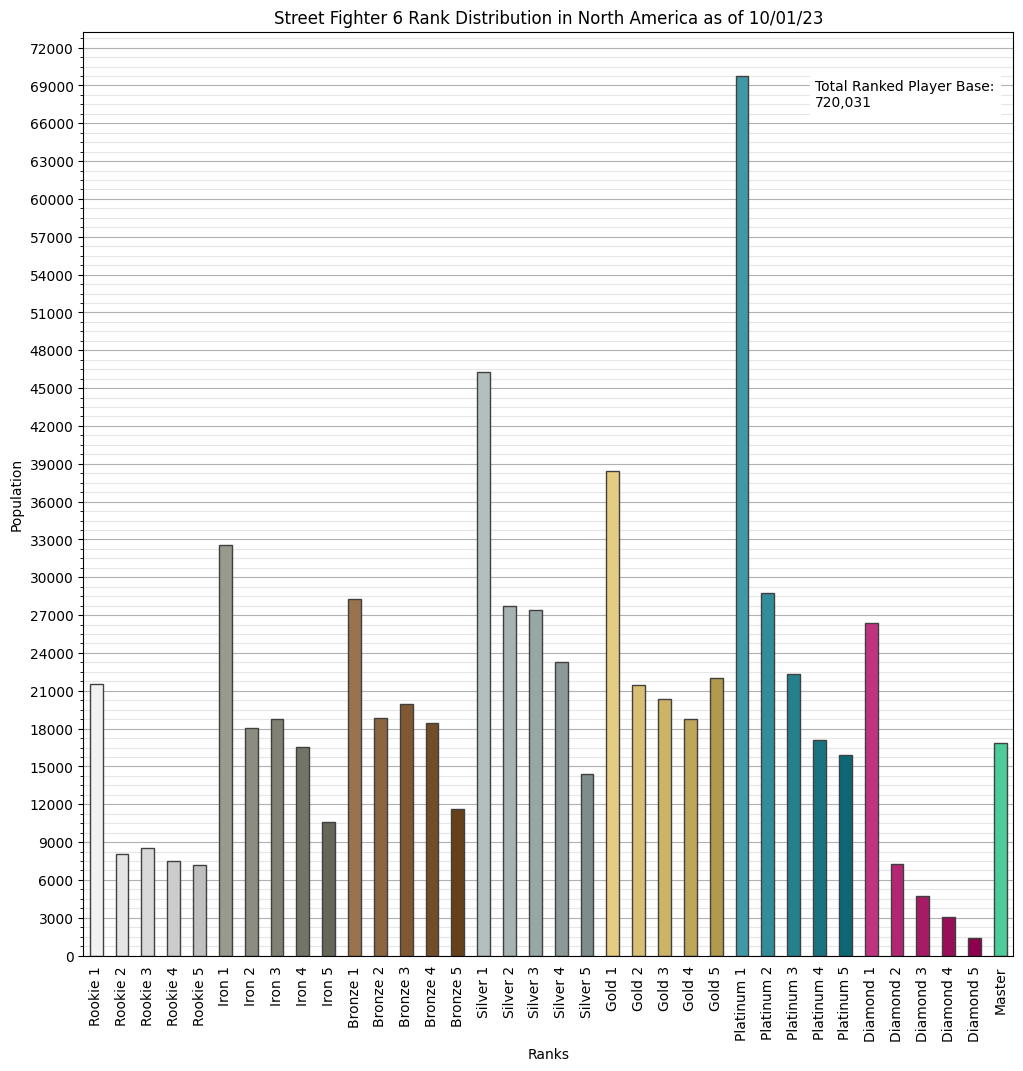

In [22]:
# Create a dictionary with the base rgb values; 
# Use those base values to decrease in values as the tier in the same rank group goes higher (differentiate different tiers in the same group)
rank_rgb = {"Rookie": (0.95, 0.95, 0.95), 
            "Iron": (0.6, 0.6, 0.55), 
            "Bronze": (0.6, 0.45, 0.3), 
            "Silver": (0.7, 0.75, 0.75), 
            "Gold": (0.9, 0.8, 0.5), 
            "Platinum": (0.25, 0.6, 0.65), 
            "Diamond": (0.75, 0.2, 0.5), 
            "Master": (0.3, 0.8, 0.6)}
rank_rgb_array = np.asarray(list(rank_rgb.values()))

rank_color_palette = []

for rank in range(7):
    for tier in range(5):

        rank_tier_darkness = tier/20 # Change the value of the rgb to make it darker for each rank tier in the same rank group
        new_rgb = rank_rgb_array[rank] - rank_tier_darkness

        rank_color_palette.append(new_rgb)

        new_rgb = [] # reset rgb values for every rank

rank_color_palette.append(rank_rgb["Master"]) # Master Rank Color


# Calculate the max y value and use it as a basis to get the right intervals to use for y ticks max value; 
# (np.linspace approach does not have nice round intervals, which I do not like)
rounded_max_total_player_count = round(adj_rank_df["Population"].max(), -3)
number_of_y_tick_intervals = 25
y_tick_intervals = int(round(rounded_max_total_player_count / number_of_y_tick_intervals, -3))
upper_y_tick = rounded_max_total_player_count + y_tick_intervals


# Plot the data as a bar graph
fig, ax = plt.subplots()

adj_rank_df.plot(kind="bar", 
                 x="Rank", 
                 y="Population", 
                 yticks=range(0, upper_y_tick, y_tick_intervals), 
                 ax=ax,
                 title="Street Fighter 6 Rank Distribution in North America as of " + (date.today()).strftime("%m/%d/%y"), 
                 color=rank_color_palette, 
                 edgecolor=(0.25, 0.25, 0.25), 
                 grid=True, 
                 legend=False) 

ax.set_axisbelow(True)
ax.grid(axis="x", visible=False)
ax.grid(axis="y", which="minor", color=(0.9, 0.9, 0.9))
ax.minorticks_on()

fig.set_size_inches(12, 12)

plt.figtext(0.735, 0.818, total_player_base_text, {"backgroundcolor":"white"})

plt.tick_params(axis="x", which="both", bottom=False)

plt.xlabel("Ranks")
plt.ylabel("Population")


plt.show()

### Data Frame of the Total Player Count in Each Rank Groups

In [23]:
# Create a new dataframe for which tier of ranks e.g. Rookie 1, Bronze 1, Rookie 1, etc. into one df
def group_ranks(tier):
    """
    Group ranks that end with a specified number together (Rookie 1, Iron 1, Bronze 1...)
    Master rank has the population values for the 1st tiered groups; 0 for the rest
    """
    tier_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == str(tier))]

    if tier == 1: 
        tier_df.loc[np.inf] = adj_rank_df[(adj_rank_df["Rank"] == "Master")].values.tolist()[0]
    else:
        tier_df.loc[np.inf] = ["Master", 0] # add Master rank to maintain the same array shape; Would not be captured since it does not have a number at the end
    
    tier_df = tier_df.reset_index(drop=True)

    return tier_df

rank_tiers = []
for i in range(1, 6):
    rank_tiers.append(group_ranks(i))


for df in rank_tiers:
    display(df)
    print(f"Total Ranked Player Base:\n{total_player_base:,}")

C:\Users\Binaryxx Sune\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Rank,Population
0,Rookie 1,21523
1,Iron 1,32573
2,Bronze 1,28302
3,Silver 1,46253
4,Gold 1,38418
5,Platinum 1,69779
6,Diamond 1,26401
7,Master,16833


Total Ranked Player Base:
720,031


,Rank,Population
0,Rookie 2,8092
1,Iron 2,18055
2,Bronze 2,18850
3,Silver 2,27696
4,Gold 2,21455
5,Platinum 2,28779
6,Diamond 2,7265
7,Master,0


Total Ranked Player Base:
720,031


,Rank,Population
0,Rookie 3,8571
1,Iron 3,18788
2,Bronze 3,19926
3,Silver 3,27396
4,Gold 3,20377
5,Platinum 3,22366
6,Diamond 3,4718
7,Master,0


Total Ranked Player Base:
720,031


,Rank,Population
0,Rookie 4,7511
1,Iron 4,16526
2,Bronze 4,18434
3,Silver 4,23257
4,Gold 4,18770
5,Platinum 4,17118
6,Diamond 4,3050
7,Master,0


Total Ranked Player Base:
720,031


,Rank,Population
0,Rookie 5,7152
1,Iron 5,10571
2,Bronze 5,11592
3,Silver 5,14382
4,Gold 5,21980
5,Platinum 5,15894
6,Diamond 5,1386
7,Master,0


Total Ranked Player Base:
720,031


### Stacked Bar Chart of the Total Player Count in Each Rank Groups

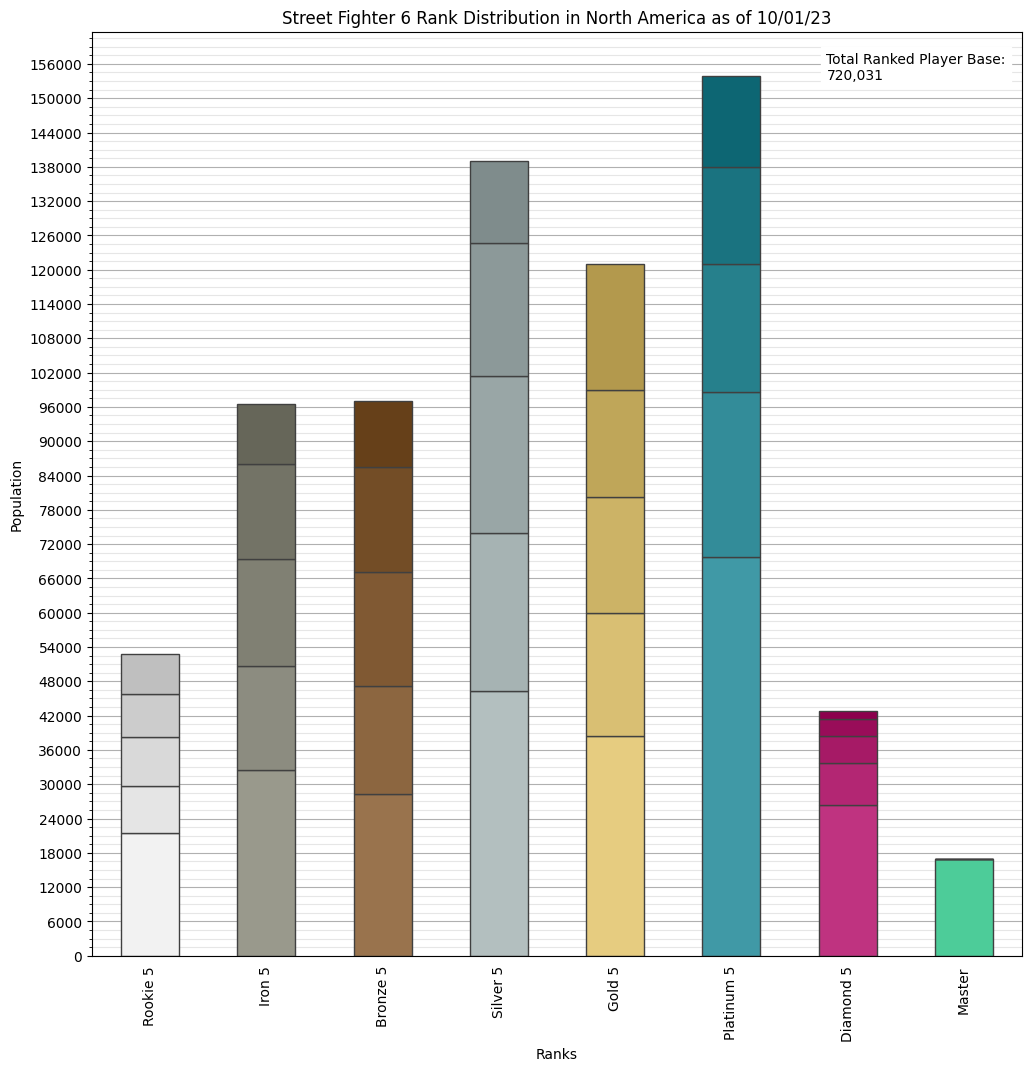

In [24]:
fig, ax = plt.subplots()
stacked_bar_starting_bottom_height = np.zeros(8)

# Create new rgb values; the order is different from previous graph's color palette
stacked_bar_palettes = [[] for _ in range(5)]

for tier in range(5):
    for rank in range(8):

        rank_tier_darkness = tier/20 # Change the value of the rgb to make it darker for each rank tier in the same rank group
        new_rgb = rank_rgb_array[rank] - rank_tier_darkness

        stacked_bar_palettes[tier].append(new_rgb)

        new_rgb = [] # reset rgb values for every rank


# Plot the bar graph for each tier, plotting the bar where the previous tier left off to stack the bars of the same rank group together
for idx, tier_group in enumerate(rank_tiers):
    tier_group.plot(kind="bar",
                    ax=ax,
                    x="Rank", 
                    y="Population",
                    bottom=stacked_bar_starting_bottom_height,
                    title="Street Fighter 6 Rank Distribution in North America as of " + (date.today()).strftime("%m/%d/%y"), 
                    color=stacked_bar_palettes[idx],
                    edgecolor=(0.25, 0.25, 0.25),
                    legend=False,
                    grid=True)

    stacked_bar_starting_bottom_height += rank_tiers[idx]["Population"].values # update the starting height so that the next tier starts where the previous tier ends

stacked_max_y_values_array = stacked_bar_starting_bottom_height # At the end of the loop, the last tier group is added to the bottom heights, creating an array of the max y values
stacked_max_y_value = int(np.max(stacked_max_y_values_array))
stacked_y_tick_interval_number = 25
stacked_y_tick_intervals = int(round(stacked_max_y_value / stacked_y_tick_interval_number, -3))
stacked_max_y_tick = stacked_max_y_value + stacked_y_tick_intervals
ax.set_yticks(range(0, stacked_max_y_tick, stacked_y_tick_intervals))

ax.set_axisbelow(True)
ax.grid(axis="x", visible=False)
ax.grid(axis="y", which="minor", color=(0.9, 0.9, 0.9))
ax.minorticks_on()

fig.set_size_inches(12, 12)

plt.figtext(0.737, 0.84, total_player_base_text, {"backgroundcolor":"white"})

plt.tick_params(axis="x", which="both", bottom=False)

plt.xlabel("Ranks")
plt.ylabel("Population")


plt.show()

### Data Frame of Cumulative Percentile of Each Rank

In [25]:
rank_population_sum = sum(list(adj_rank_df["Population"].values))
rank_list = list(adj_rank_df["Rank"].values)

def percentile_calculator(population):
    percentile = round((population / rank_population_sum)*100, 2)
    return percentile

rank_percentile_list = adj_rank_df["Population"].apply(percentile_calculator)
rank_cumulative_percentile_list = round(rank_percentile_list.cumsum(),1)

rank_percentile_df = pd.DataFrame([rank_list, rank_cumulative_percentile_list]).transpose() #NOTE: Removing ,
rank_percentile_df = rank_percentile_df.rename({0:"Rank", 1:"Cumulative Percentile"}, axis=1)

display(rank_percentile_df)
print(total_player_base_text)

,Rank,Cumulative Percentile
0,Rookie 1,3.0
1,Rookie 2,4.1
2,Rookie 3,5.3
3,Rookie 4,6.3
4,Rookie 5,7.3
5,Iron 1,11.9
6,Iron 2,14.4
7,Iron 3,17.0
8,Iron 4,19.3
9,Iron 5,20.7


Total Ranked Player Base:
720,031


### Chart of Cumulative Percentile of Each Rank

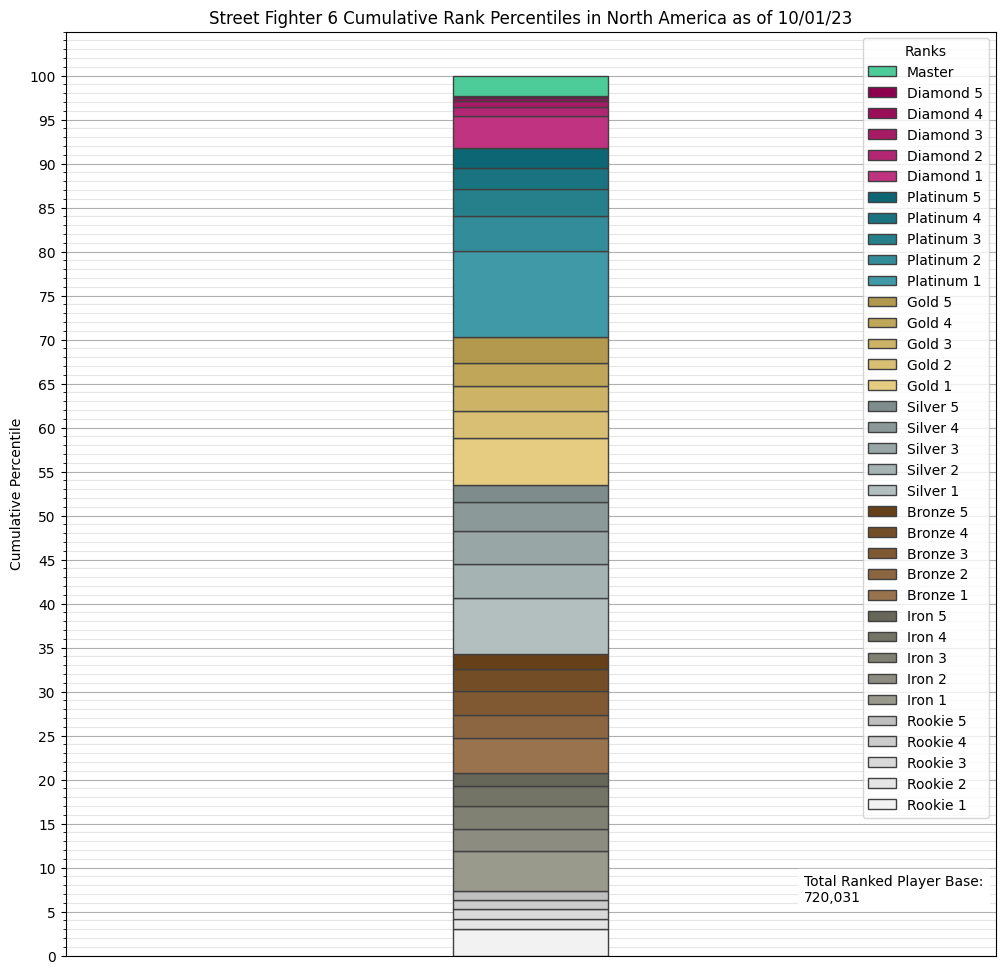

In [26]:
fig, ax = plt.subplots()
percentile_max = 101 # Over 100 to have the tick label for 100
percentile_intervals = 5
percentile_starting_bottom_height = 0

for i in rank_percentile_df.index:
    percentile_df = pd.DataFrame([rank_list[i], rank_percentile_list[i]]).transpose()
    percentile_df.plot(kind="bar",
                       ax=ax,
                       yticks=range(0, percentile_max, percentile_intervals), 
                       width=0.1,
                       bottom=percentile_starting_bottom_height,
                       title="Street Fighter 6 Cumulative Rank Percentiles in North America as of " + (date.today()).strftime("%m/%d/%y"), 
                       color=rank_color_palette[i],
                       edgecolor=(0.25, 0.25, 0.25),
                       grid=True)
    percentile_starting_bottom_height += rank_percentile_list[i] # Update the starting bottom height for all values in array

ax.set_axisbelow(True)
ax.grid(axis="x")
ax.grid(which="minor", color=(0.9, 0.9, 0.9))
ax.minorticks_on()

handles, _ = ax.get_legend_handles_labels()
labels = rank_list
ax.legend(handles[::-1], labels[::-1], title="Ranks")

fig.set_size_inches(12, 12)

plt.figtext(0.74, 0.155, total_player_base_text, {"backgroundcolor":"white"})

plt.tick_params(bottom=False, labelbottom=False)
plt.ylabel("Cumulative Percentile")


plt.show()